# Data Science Challenge

Author: Daren Eiri

Date: 02/12/2020

## Assignment
Download the publicly available dataset corresponding to Protocol H, “A Randomized Trial Comparing Continuous Glucose Monitoring With and Without Routine Blood Glucose Monitoring in Adults with Type 1 Diabetes” from the following website:
https://public.jaeb.org/t1dx/stdy

This dataset was collected as part of a clinical trial and contains data from persons with
diabetes who use insulin pumps and continuous glucose monitoring.

Please come up with a glucose prediction algorithm that predicts glucose levels
30 minutes into the future. Please assess the performance of your algorithm.
You should focus on the data in table HDeviceCGM. If desired, you may add
additional predictors, though a CGM-only solution is sufficient.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 999

In [2]:
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()
  plt.close()
  
  return

def run_arima_model(df, ts, p, d, q):
  """
  Run ARIMA model
  """
  # fit ARIMA model on time series
  model = ARIMA(df[ts], order=(p, d, q))  
  results_ = model.fit(disp=-1)  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[ts][-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df[ts]))
  
  # plot fit
  plt.plot(df[ts])
  plt.plot(results_.fittedvalues, color = 'red')
  plt.title('For ARIMA model (%i, %i, %i) for ts %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, ts, rss, rmse))
  plt.ylabel('GlucoseValue (mg/dl)')  
  plt.xlabel('Interval Count (5 mins)')  

  plt.show()
  plt.close()
  
  return results_

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        results_ = model.fit(disp=-1)  

        # get lengths correct to calculate RSS
        len_results = len(results_.fittedvalues)
        ts_modified = history[-len_results:]

        # calculate root mean square error (RMSE) and residual sum of squares (RSS)
        rss = sum((results_.fittedvalues - ts_modified)**2)
        rmse = np.sqrt(rss / len(history))
    return rmse

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [3]:
data = pd.read_csv('raw_data/HDeviceCGM.txt', sep="|")

## A Quick Glance At The Data
From `Protocol_H/ReadMe.rtf`

HDeviceCGM 
Description - One record per CGM reading

|Name                         |Data Type|Description                                 |Nullable|Min|Max|Possible_Values|
|-----------------------------|---------|--------------------------------------------|--------|---|---|---------------|
|RecID                        |int      |Unique record ID in table                   |NO      |   |   |               |
|ParentHDeviceUploadsID       |int      |RecID from tblHDeviceUploads                |NO      |   |   |               |
|PtID                         |varchar  |Participant ID                              |NO      |   |   |               |
|SiteID                       |Int      |Site Identifier                             |NO      |   |   |               |
|DeviceDtTmDaysFromEnroll     |Int      |Device date number of days from enrollment  |NO      |   |   |               |
|DeviceTm                     |Time     |Device Time                                 |NO      |   |   |               |
|DexInternalDtTmDaysFromEnroll|Int      |Internal date number of days from enrollment|NO      |   |   |               |
|DexInternalTm                |Time     |Internal time                               |NO      |   |   |               |
|RecordType                   |varchar  |Type of data (CGM, Calibration, etc)        |NO      |   |   |               |
|GlucoseValue                 |decimal  |Glucose value (units: mg/dL)                |YES     |   |   |               |

## Initial Impressions and Concerns
* As RecID increases, DeviceTm and DexInternalTm decrease. I would have expected the time columns to increase as RecID increased. It seems like when the logging was imported, it was in reverse order. 
* What are the unique values associated with some of these columns? 
* Looks like the important columns to be concerned with will be PtID, DeviceTm, and GlucoseValue (the target predictor). 

In [4]:
data.head()

,RecID,ParentHDeviceUploadsID,PtID,SiteID,DeviceDtTmDaysFromEnroll,DeviceTm,DexInternalDtTmDaysFromEnroll,DexInternalTm,RecordType,GlucoseValue
0,1655236,782,183,12,-6,05:35:41,-6.0,12:37:02,CGM,162.0
1,1655237,782,183,12,-6,05:30:41,-6.0,12:32:02,CGM,164.0
2,1655238,782,183,12,-6,05:25:41,-6.0,12:27:02,CGM,168.0
3,1655239,782,183,12,-6,05:20:41,-6.0,12:22:02,CGM,169.0
4,1655240,782,183,12,-6,05:15:41,-6.0,12:17:02,CGM,170.0


In [5]:
print("We have", data.PtID.nunique(), "unique patients in our dataset.")

We have 226 unique patients in our dataset.


## Review Data Types
We need to convert DeviceTm to datetime format in order to do a proper time series analysis. 

In [6]:
data.dtypes

RecID                              int64
ParentHDeviceUploadsID             int64
PtID                               int64
SiteID                             int64
DeviceDtTmDaysFromEnroll           int64
DeviceTm                          object
DexInternalDtTmDaysFromEnroll    float64
DexInternalTm                     object
RecordType                        object
GlucoseValue                     float64
dtype: object

## Deep Dive: Clean Up The Data
It looks like `DeviceDtTmDaysFromEnroll` can be used as as a proxy for "day". And we can use `DeviceTm` to get the time of day. It's unfortunate that there is no proper datetime column! 
 
My goal is to do a univariate forecast model to predict `GlucoseValue` at least 30 minutes into the future. 

In [7]:
df = data[['PtID', 'DeviceTm', 'DeviceDtTmDaysFromEnroll', 'RecordType', 'GlucoseValue']]

* Subset the data so that it only includes CGM. 
* Remove nulls (if any).
* Convert `DeviceTm` to from object to timedelta.
* Resolve reverse ordering of `DeviceTime` and `DeviceDtTmDaysFromEnroll` so that the first value is the earliest data point.
* Sometimes there is only one 5-minute measurement per day, which isn't very useful.
* Othertimes there are consecutive 5-minute readings. How long this consecutive sequence lasts varies.
* Not every CGM reading is done in 5-minute intervals. Sometimes the last reading was done 40+ minutes previously. 

In [8]:
# Subset data to only CGM
df = df[df['RecordType']=="CGM"]

# Check for nulls
display(df.isnull().sum())

# Convert DeviceTm to timedelta
df['Time'] = pd.to_timedelta(df.DeviceTm)

# Reverse time-related columns so that it ascends instead of descends, per PtID
df = df.sort_values(['DeviceDtTmDaysFromEnroll', 'Time'], ascending=True) \
                        .groupby('PtID') \
                        .apply(pd.DataFrame)

display(df.head(10))

PtID                        0
DeviceTm                    0
DeviceDtTmDaysFromEnroll    0
RecordType                  0
GlucoseValue                0
dtype: int64

,PtID,DeviceTm,DeviceDtTmDaysFromEnroll,RecordType,GlucoseValue,Time
12304724,170,17:53:22,-595,CGM,52.0,17:53:22
12304723,170,17:58:22,-595,CGM,54.0,17:58:22
12304722,170,18:03:22,-595,CGM,57.0,18:03:22
12304721,170,18:08:22,-595,CGM,60.0,18:08:22
12304720,170,18:13:22,-595,CGM,62.0,18:13:22
12304719,170,18:18:22,-595,CGM,64.0,18:18:22
12304718,170,18:23:22,-595,CGM,68.0,18:23:22
12304717,170,18:28:22,-595,CGM,73.0,18:28:22
12304716,170,18:33:22,-595,CGM,79.0,18:33:22
12304715,170,18:38:22,-595,CGM,85.0,18:38:22


### Resolve Inconsistent Sampling Issues
By calculating the time difference between each consecutive reading per patient, per day, we find that CGM readings aren't always 5 minutes apart. And some patients wear their monitor for such a short period of time, or for all day. For the the scope of this model, let's standardize our data and limit the size of patient data, given that the interval between each reading is always 5 minutes. 

In [9]:
df['Time_Delta'] = df.groupby(['PtID','DeviceDtTmDaysFromEnroll'])['Time'].diff()

In [10]:
# Here we see the max value of Time_Delta, or the Time difference between each row, given Patient and day. 
display(df.Time_Delta.describe())
print("The max time difference between two consective rows for a patient on the same day is", df.Time_Delta.max(),"!")

count                  14752194
mean     0 days 00:05:12.709353
std      0 days 00:06:40.903802
min             0 days 00:00:00
25%             0 days 00:05:00
50%             0 days 00:05:00
75%             0 days 00:05:00
max             0 days 23:04:02
Name: Time_Delta, dtype: object

The max time difference between two consective rows for a patient on the same day is 0 days 23:04:02 !


In [11]:
NUM_MEASUREMENTS=30

df['count'] = df.groupby((df['Time_Delta'] != df['Time_Delta'].shift(1)).cumsum()).cumcount()+1

# We need to create a new DF where we can select data where
# there are NUM_MEASUREMENTS consecutive recordings, per patient per day
df['diff'] = df.groupby(['PtID', 'DeviceDtTmDaysFromEnroll'])['count'].diff()!=1
df['cusm'] = df.groupby(['PtID', 'DeviceDtTmDaysFromEnroll'])['diff'].cumsum()
df = df.loc[df.groupby(['PtID','DeviceDtTmDaysFromEnroll', 'cusm']).transform('count')['diff'] >= NUM_MEASUREMENTS]
print("The longest streak of GlucoseValue recordings for continuous 5 minute readings is", df['count'].max(), \
      "which is PtID", df[df['count']==df['count'].max()]['PtID'].values[0])
sub_df = df.groupby(['PtID','DeviceDtTmDaysFromEnroll']).head(NUM_MEASUREMENTS).copy()


The longest streak of GlucoseValue recordings for continuous 5 minute readings is 287 which is PtID 187


In [12]:
sub_df.reset_index(drop=True, inplace=True)

sub_df['cumcount'] = sub_df.groupby(['PtID','DeviceDtTmDaysFromEnroll']).cumcount()

In [13]:
new_df = sub_df[['PtID', 'cumcount', 'GlucoseValue']].reset_index(drop=True)

Do our glucose values look right? 
From https://www.guinnessworldrecords.com/world-records/highest-blood-sugar-level/

    Michael Patrick Buonocore (USA) (b. 19 May 2001), survived a blood sugar level of 147.6 mmol/L (2,656 mg/dl) when admitted to the Pocono Emergency Room in East Stroudsburg, Pennsylvania, USA, on 23 March 2008. The normal blood sugar range is between 4.4 to 6.6 mmol/L (80-120 mg/dl). 

Our data is in mg/dl so although our max value of 320 is quite high, it's likely not an error.

We've cut our patient population quite a bit, compared to what we originally have (226). It seems that many patients do not meet the strict critera we've set.

In [14]:
new_df.GlucoseValue.describe()

count    1140.000000
mean      156.766667
std        61.220108
min        39.000000
25%       113.000000
50%       146.500000
75%       201.000000
max       339.000000
Name: GlucoseValue, dtype: float64

In [15]:
print("We have", new_df.PtID.nunique(), "unique patients in our dataset.")

We have 8 unique patients in our dataset.


Now we can get a preview of what our data looks like. For each patient, we have a sequence of `GlucoseValue` readings, each 5 minutes apart, in sequence. So each patient has 30 5-minute intervals of data. 

In [16]:
new_df.head(20)

,PtID,cumcount,GlucoseValue
0,170,0,157.0
1,170,1,153.0
2,170,2,144.0
3,170,3,130.0
4,170,4,119.0
5,170,5,112.0
6,170,6,104.0
7,170,7,94.0
8,170,8,81.0
9,170,9,76.0


What do all the patient's `GlucoseValue` look like over time? 

If a patient has multiple lines in a plot, then there are multiple days of continuous recordings that are available. 

Looks like the values vary over time for each patient.

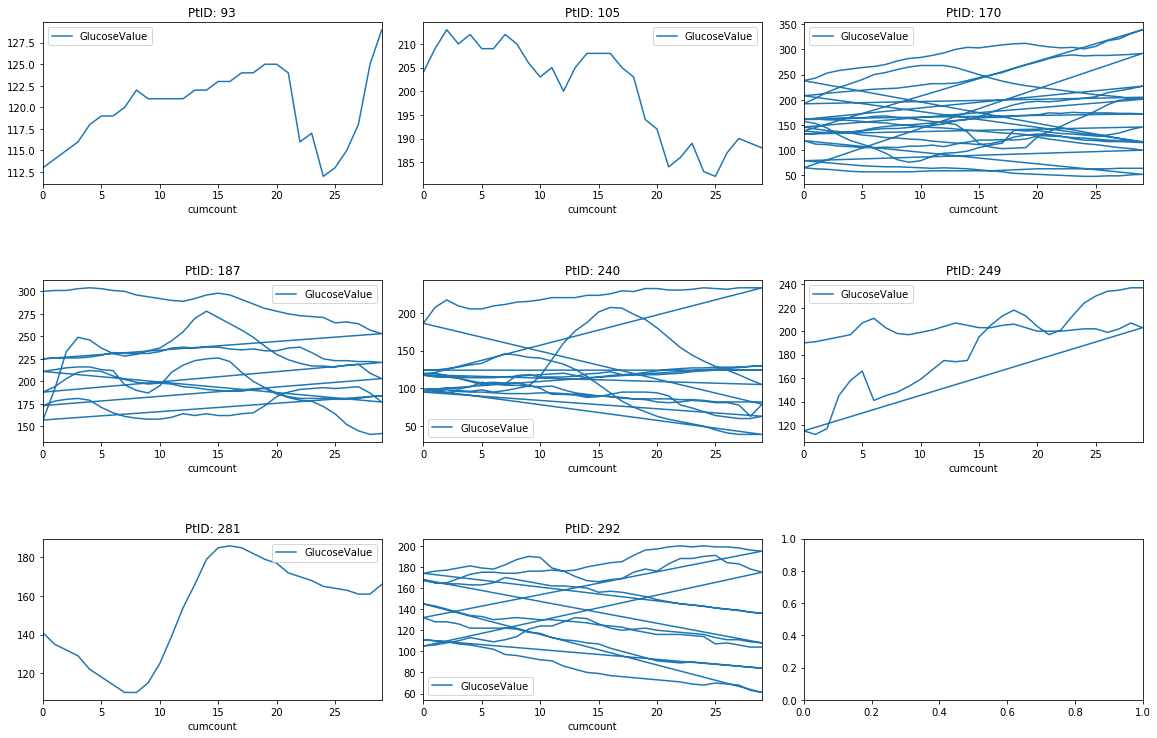

In [17]:
grouped = new_df.groupby('PtID')
ncols=3
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,10))
fig.tight_layout()
for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(x='cumcount', y='GlucoseValue',ax=ax)
    ax.set_title('PtID: {}'.format(key))

ax.legend()
plt.subplots_adjust(hspace = 0.6)
plt.show()

# Build A Glucose Predictor Model

Now that we have data from some patients, let's see if we can predict the last 30 minutes of a patient's `GlucoseValue` measurement for a single patient. 

In [18]:
Pt193 = new_df[new_df['PtID']==93].reset_index(drop=True)

With ARIMA, we need to validate some assumptions. One is to see if we need to transform the data make it stationary. Since we have a significant result, we do not need to take additional steps for this patient. Supposedly. 

In [19]:
result = adfuller(Pt193.GlucoseValue)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.294717
p-value: 0.015116


Now we need to determine our p and q values. One way to do this is to create an ACF and PACF plot and see when the line crosses the upper confidence interval for the first time. Based on ACF, p can be set to 4. Based on PACF, q can be set to 2.

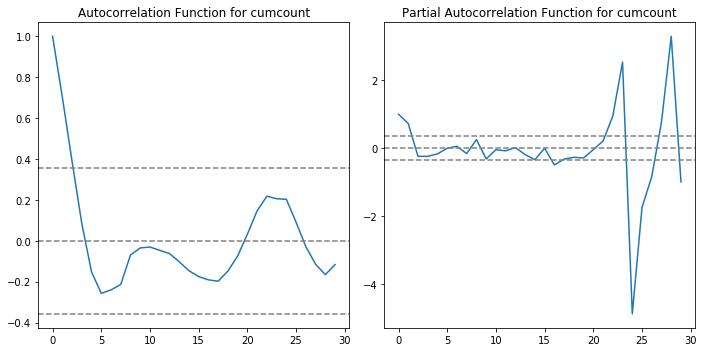

In [20]:
lag_acf = acf(np.array(Pt193['GlucoseValue']), fft=True)
lag_pacf = pacf(np.array(Pt193['GlucoseValue']), nlags=40)
plot_acf_pacf(df = Pt193, ts = 'cumcount')

Now let's see how the model works for the entire series. 

This looks like it could be improved on, based on the RMSE value. The plot is misleading since it's estimating the GlucoseValue only one step ahead the previous value (thus the appearance of a lead in the red fitted line)

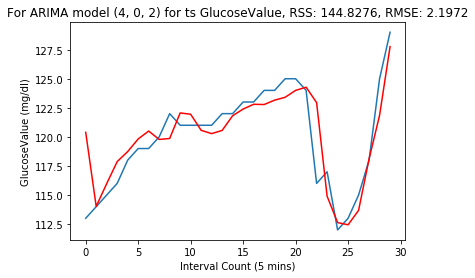

In [21]:
model_AR = run_arima_model(df = Pt193, 
                           ts = 'GlucoseValue', 
                           p = 4, 
                           d = 0, 
                           q = 2)

How does this compare if we split the data and try to predict 30 minutes into the future?

This is particularly challenging since coincidentally for this patient, around the 24th 5-minute interval, the glucose values were on a downward trend and go back up. 

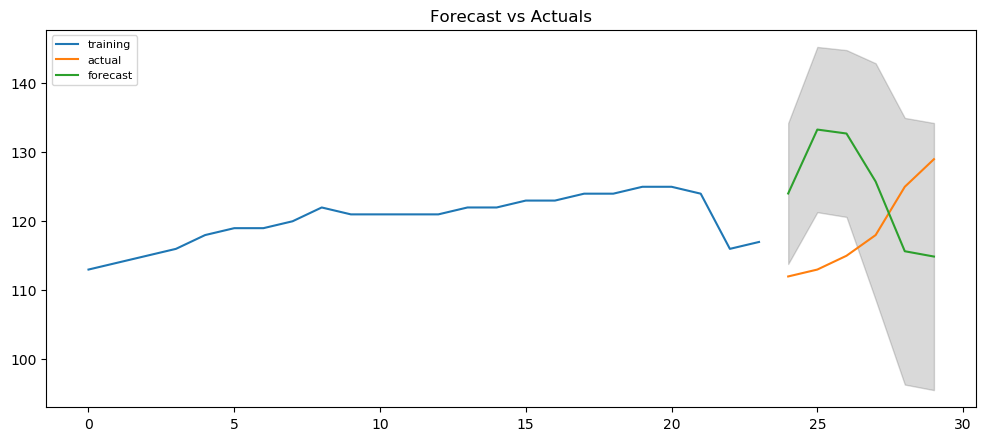

In [22]:
train = Pt193.GlucoseValue[:24]
test = Pt193.GlucoseValue[24:]

model = ARIMA(train, order=(4,0,2))
fitted = model.fit(disp=-1)  
fc, se, conf = fitted.forecast(6, alpha=0.05)  # 95% conf
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Let's try to do a grid search with ARIMA to see if we can possibly obtain lower values of RMSE and a better prediction of GlucoseValues.

Spoiler alert: looks like the best one was selected already!

In [23]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3) 
q_values = range(0, 3)
evaluate_models(Pt193.GlucoseValue, p_values, d_values, q_values)

Best ARIMA(4, 0, 2) RMSE=1.143


## Let's Use A Patient With More Data
What about for the longest patient data, identified earlier? Does the model improve with more data?

We'll go through the same process, but Pt 187 has 287 5-minute intervals, which is nearly a full day's worth of continuous CGM readings. As before, we need to check our assumptions for ARIMA and if they're not met, transform the data (which in itself indiciates maybe something other than ARIMA is more appropriate). We'll run another grid search to find the best p,d,q parameters and see how well the last ~30 minutes perform compared to the actual. 

In [24]:
Pt187 = df[(df.PtID==187) & (df.DeviceDtTmDaysFromEnroll==-174)]
Pt187 = Pt187[['count', 'GlucoseValue']].reset_index(drop=True)
display(Pt187.head(5))
display(Pt187.describe())

,count,GlucoseValue
0,1,300.0
1,2,301.0
2,3,301.0
3,4,303.0
4,5,304.0


,count,GlucoseValue
count,287.000000,287.000000
mean,144.000000,184.620209
std,82.993976,56.515658
min,1.000000,60.000000
25%,72.500000,143.000000
50%,144.000000,179.000000
75%,215.500000,224.000000
max,287.000000,304.000000


What does the data look like over time? 

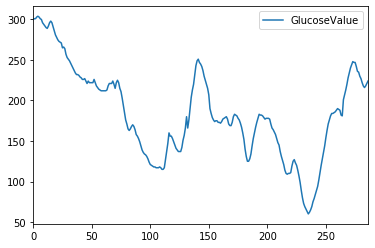

In [25]:
Pt187.plot(y='GlucoseValue')

Transform data so that our assumptions regarding the data are satisifed.

Raw Values
ADF Statistic: -2.781295
p-value: 0.060996

Log Values
ADF Statistic: -2.813448
p-value: 0.056378

Log Diff Values
ADF Statistic: -5.238539
p-value: 0.000007


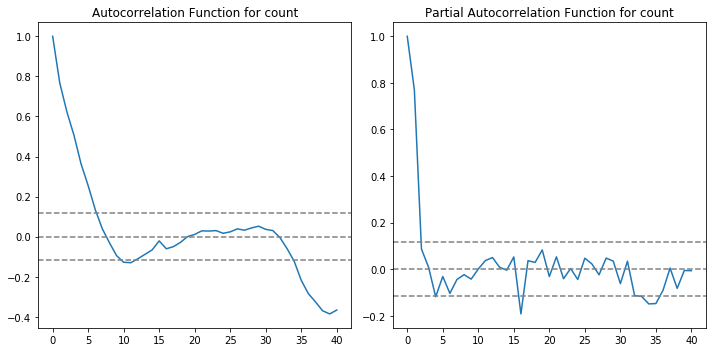

In [26]:
print("Raw Values")
result = adfuller(Pt187.GlucoseValue)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print("\nLog Values")
Pt187['GlucoseValue_log'] = Pt187['GlucoseValue'].apply(lambda x: np.log(x))
result = adfuller(Pt187.GlucoseValue_log)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print("\nLog Diff Values")
Pt187['GlucoseValue_log_diff'] = Pt187['GlucoseValue_log'].diff()
Pt187.dropna(inplace=True)
result = adfuller(Pt187.GlucoseValue_log_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


lag_acf = acf(np.array(Pt187['GlucoseValue_log_diff']), fft=True)
lag_pacf = pacf(np.array(Pt187['GlucoseValue_log_diff']))
plot_acf_pacf(df = Pt187, ts = 'count')

Run another gird search using the transformed data that had a significant result. This will take a while. 

We find that the RMSE value is quite minimized compared to our previous patient with less data. The previous patient had an RMSE of 2.1972

In [27]:
p_values = [0, 1, 2, 4, 6]
d_values = range(0, 3) 
q_values = range(0, 3)
evaluate_models(Pt187.GlucoseValue_log_diff, p_values, d_values, q_values)

Best ARIMA(6, 0, 2) RMSE=0.020


Let's hold out the last few intervals of the data and visually see how well the forecast compares to the actual, given the parameters above.

The 95% CI includes the actual data points

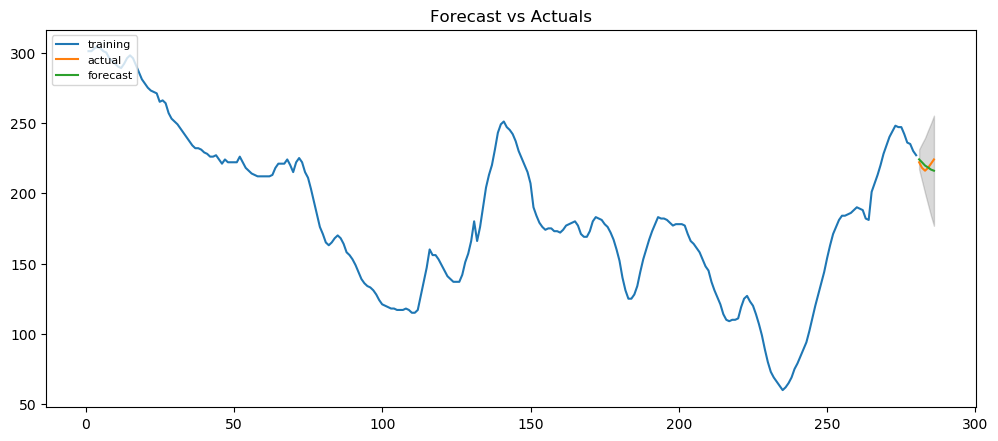

In [28]:
train = Pt187.GlucoseValue[:280]
test = Pt187.GlucoseValue[280:]

model = ARIMA(train, order=(6,0,2))
fitted = model.fit(disp=-1)  
fc, se, conf = fitted.forecast(6, alpha=0.05)  # 95% conf
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Conclusions

As a first initial step towards building a model to predict `GlucoseValue` thirty minutes into the future, I have the following insights: 
  * The raw data is inconsistent in its recording intervals; it's not always 5 minutes apart. 
  
  * Not having date and timestamps associated with each recording, I had to use proxies to assume how the recordings should be ordered.
  
  * There was variation in how long sequenced recordings would last.
  
      * I restricted my dataset to only select a patient's recording for an hour, with the assumption I would look at all patient data together. 
      
      * Instead, I looked at a single patient's data and modeled/assessed for only that patient.
      
      * I also expanded my effort by seeing how that compares to a patient with many more time intervals, to see how my error values would change (it decreased quite a bit). 

# Next Steps

If I had additional time, I would proceed with looking at how well a model performs given data from every patient. Would aggregating patient data improve the model? Possibly by creating a model for each patient, and choose the model that performs best across all models. 

Alternatively, we could dedicate time to a personalized GlucoseValue predictor. One person's glucose levels are independent of someone else's (age, health, fitness, diet, etc). Thus, having a population share a single model may not be as accurate. 

We could also look at additional models (e.g. a seasonal ARIMA) since assumingly there is a cyclical time-component of glucose given daily behavior patterns (sleep time, eating, etc.). This is especially true if we look at longer-term data for individual patients. Such a model could be compared to non-seasonal ARIMA through AIC. 

What would performance/evaluation look like if we had a sliding window of 30 minute across the patient's dataset? Instead of assessing the model performance at the last 30 minutes, how does the model perform as more time samples are provided? Is there an ideal number of recordings required before our error term plateaus? 

Additionaly, we could look outside of ARIMA-based models and implement a sequence-based neural network (GRU, LSTM).  
